<a href="https://colab.research.google.com/github/anushkabisanii/social_media_post_analysis/blob/main/Social_media_post_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 7.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('/political_social_media.csv',encoding="ISO-8859-1")

In [ ]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [ ]:
df.dropna(inplace=True, axis=1)
df.reset_index(drop=True)
df['message'].replace(['policy','attack','support','information','mobilization','personal','constituency','media','other'],[1,2,3,4,5,6,7,8,0],inplace=True)
df['bias'].replace(['partisan','neutral'],[1,2],inplace=True)
df['bias'].replace(['twitter','facebook'],[1,2],inplace=True)
df['audience'].replace(['national','constituency'],[1,2],inplace=True)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,message:confidence,bioid,embed,id,label,source,text
0,766192484,False,finalized,1,8/4/15 21:17,1,1.0,1,1.0,1,1.0,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,1,1.0,1,1.0,2,1.0,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,1,1.0,2,1.0,3,1.0,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,1,1.0,2,1.0,1,1.0,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,1,1.0,1,1.0,1,1.0,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...


In [ ]:
df.drop(columns=["_unit_id","_golden","_unit_state","_last_judgment_at","audience:confidence","bias:confidence","message:confidence","bioid","embed","id","label"], inplace=True)
df.head()

,_trusted_judgments,audience,bias,message,source,text
0,1,1,1,1,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,1,1,1,2,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,1,1,2,3,twitter,Please join me today in remembering our fallen...
3,1,1,2,1,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,1,1,1,1,twitter,.@amazon delivery #drones show need to update ...


In [ ]:
df.shape

(5000, 6)

In [ ]:
df.columns

Index(['_trusted_judgments', 'audience', 'bias', 'message', 'source', 'text'], dtype='object')

In [ ]:
df.dtypes

_trusted_judgments     int64
audience               int64
bias                   int64
message                int64
source                object
text                  object
dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

df_text_final=df['text']
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
df_text=vectorizer.fit_transform(df_text_final)
print(df_text)

  (0, 552)	0.15342295814081838
  (0, 1349)	0.37698388198465016
  (0, 2025)	0.46060506139401586
  (0, 1854)	0.3044673590069145
  (0, 1087)	0.5473391608862196
  (0, 2236)	0.36841755250729313
  (0, 2307)	0.3068802752240335
  (1, 1348)	0.12118378144591152
  (1, 2100)	0.44572468201220594
  (1, 407)	0.4135549568954739
  (1, 206)	0.12952380554197554
  (1, 666)	0.36588024533906194
  (1, 1297)	0.3700624214457812
  (1, 1859)	0.126937618810559
  (1, 1143)	0.32809164376736016
  (1, 2835)	0.3378301166635448
  (1, 552)	0.1351047091104849
  (1, 1854)	0.2681148536747105
  (2, 2319)	0.30140492316534834
  (2, 2657)	0.15820987890894567
  (2, 1103)	0.09765154435755
  (2, 2403)	0.19731163470156696
  (2, 1731)	0.22334410206999084
  (2, 714)	0.2805441727533909
  (2, 2938)	0.20763815831393995
  :	:
  (4999, 2454)	0.22287664509796004
  (4999, 1447)	0.26070453186342735
  (4999, 1598)	0.230152529912108
  (4999, 2837)	0.23223998274048627
  (4999, 807)	0.2421455745251495
  (4999, 584)	0.16229283882117385
  (4999, 

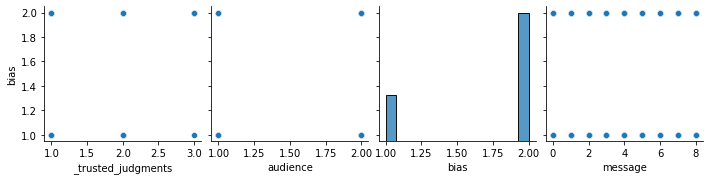

In [ ]:
sns.pairplot(df, y_vars=['bias'])

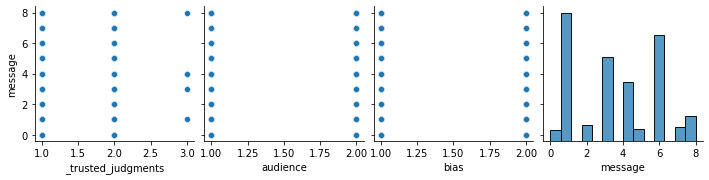

In [ ]:
sns.pairplot(df, y_vars=['message'])

<Axes: >

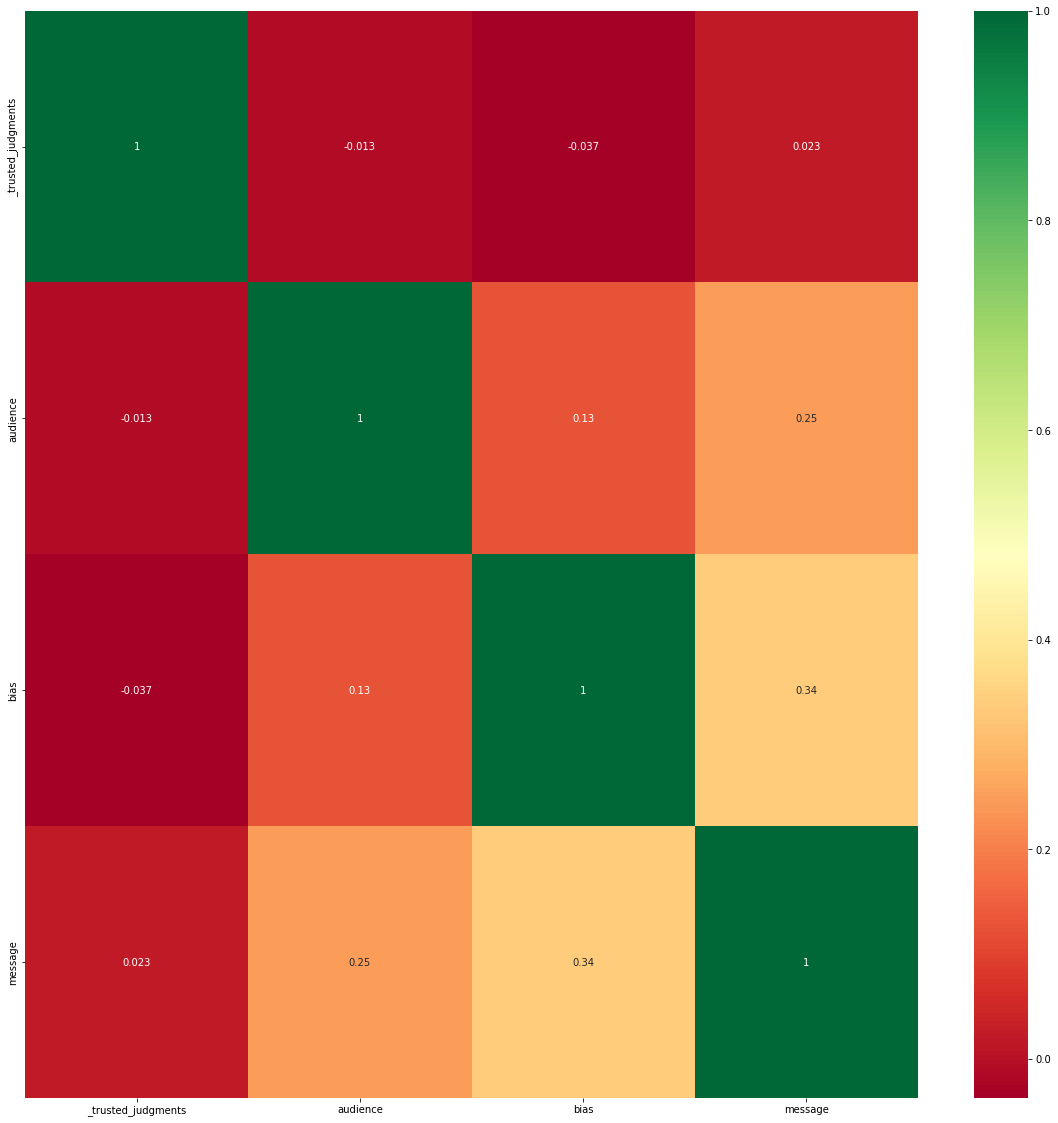

In [ ]:
%matplotlib inline
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='RdYlGn')

In [ ]:
print(df['text'])
X = df.iloc[:]
y = df.iloc[:, [3]].values
print(X)
print(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split((df_text),y,test_size=0.2, random_state = 42)

0       RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1       VIDEO - #Obamacare:  Full of Higher Costs and ...
2       Please join me today in remembering our fallen...
3       RT @SenatorLeahy: 1st step toward Senate debat...
4       .@amazon delivery #drones show need to update ...
                              ...                        
4995    I applaud Governor PerryÛªs recent decision t...
4996    Today, I voted in favor of H.R. 5016 - Financi...
4997    (Taken from posted WOKV interview)   Congressm...
4998    Join me next week for a town hall in Ocala! I'...
4999    Foreign Affairs Committee Hearing on Syria. I ...
Name: text, Length: 5000, dtype: object
      _trusted_judgments  audience  bias  message    source  \
0                      1         1     1        1   twitter   
1                      1         1     1        2   twitter   
2                      1         1     2        3   twitter   
3                      1         1     2        1   twitter   
4      

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


rf=RandomForestClassifier(n_estimators=10)
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [128],
    'max_features': [7],
    'min_samples_leaf': [8],
    'min_samples_split': [8],
    'n_estimators': [1000]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 4, verbose = 3)
grid_search.fit(X_train,y_train)
#print(grid_search.score(X_test,y_test))
rf.fit(X_train,y_train)

y_train_pred=rf.predict(X_train)

print(accuracy_score(y_train, y_train_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0.9815


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier


rf=DecisionTreeClassifier()

rf.fit(X_train,y_train)

y_train_pred=rf.predict(X_test)

print(accuracy_score(y_test, y_train_pred))

0.681


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
rf=KNeighborsClassifier()
rf.fit(X_train,y_train)

y_train_pred=rf.predict(X_test)

print(accuracy_score(y_test, y_train_pred))

0.748


In [ ]:
from sklearn.svm import SVC
rf=SVC()
rf.fit(X_train,y_train)

y_train_pred=rf.predict(X_test)

print(accuracy_score(y_test, y_train_pred))

0.785
